### Imports

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

2024-04-18 22:18:43.067582: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data Pre-processing

In [4]:
# Images are stored in the current working directory
curr_dir = os.getcwd()
data_folder_path = os.path.join(curr_dir, 'dataset')
dataset_path = os.path.join(data_folder_path, 'Brain Tumor Data Set')

healthy_brain_images_path = os.path.join(dataset_path, 'Healthy')
brain_tumor_images_path = os.path.join(dataset_path, 'Brain Tumor')

training_metadata_file_path = os.path.join(data_folder_path, 'metadata.csv')

In [5]:
training_metdata_df = pd.read_csv(training_metadata_file_path)
training_metdata_df = training_metdata_df[training_metdata_df["image"].str.contains("jpg")]
training_metdata_df.head(5)

,Unnamed: 0,image,class,format,mode,shape
0,0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
3,3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
5,5,Cancer (100).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
6,6,Cancer (1000).jpg,tumor,JPEG,RGB,"(290, 250, 3)"
7,7,Cancer (1001).jpg,tumor,JPEG,RGB,"(620, 620, 3)"


In [6]:
print(len(training_metdata_df))

4432


In [7]:
new_training_metadata_df = training_metdata_df

In [8]:
# # For faster training reduce dataset size
# import random

# new_training_metadata_df = pd.DataFrame()

# non_healthy_data = training_metdata_df[training_metdata_df["class"] == "tumor"]
# healthy_data = training_metdata_df[training_metdata_df["class"] == "normal"]
# print(len(healthy_data), len(non_healthy_data), len(non_healthy_data) + len(healthy_data))

# random_non_healthy_data = random.sample(list(non_healthy_data["image"].values), 1000)
# random_healthy_data = random.sample(list(non_healthy_data["image"].values), 1200)

# def get_row_from_image_id(image_id):
#     return training_metdata_df[training_metdata_df["image"] == image_id]

# for image_id in random_non_healthy_data:
#     row = get_row_from_image_id(image_id)
#     new_training_metadata_df = new_training_metadata_df.append(row, ignore_index=True)

# for image_id in random_healthy_data:
#     row = get_row_from_image_id(image_id)
#     new_training_metadata_df = new_training_metadata_df.append(row, ignore_index=True)

In [9]:
TEST_SIZE = 0.2
RANDOM_STATE = 42
EPOCHS = 3 
INPUT_SHAPE = (256, 256, 3)

In [10]:
train_ids, test_ids = train_test_split(new_training_metadata_df["image"], test_size = TEST_SIZE, random_state = RANDOM_STATE)

In [11]:
len(train_ids), len(test_ids)

(3545, 887)

In [12]:
def resize_image(image, size=(256, 256)):
    resized_image = image.resize(size)
    return resized_image.convert("RGB")

def load_image(image_path):
    return Image.open(image_path)

def rotate_image(image, angle):
    return image.rotate(angle, expand=True)

def flip_image(image):
    return image.transpose(Image.FLIP_LEFT_RIGHT)

def convert_image_to_numpy_array(image):
    return np.array(image)

def load_images(image_ids):
    X_classification = []
    y_classification = []

    for image_id in image_ids:
        if "Not Cancer" in image_id:
            image_path = healthy_brain_images_path + "/" + image_id
        else:
            image_path = brain_tumor_images_path + "/" + image_id

        image = load_image(image_path)
        image_resized = resize_image(image)

        classification_label = new_training_metadata_df[new_training_metadata_df['image'] == image_id]['class'].values[0]
        if classification_label == "tumor":
            classification_label = 1
        else:
            classification_label = 0

        rotated_image_60 = resize_image(rotate_image(image, 60))
        rotated_image_120 = resize_image(rotate_image(image, 120))

        flipped_image_original = flip_image(image_resized)
        flipped_image_60 = flip_image(rotated_image_60)
        flipped_image_120 = flip_image(rotated_image_120)

        # print("Image Resized Shape:", np.array(image_resized).shape)
        # print("Rotated Image 60 Shape:", np.array(rotated_image_60).shape)
        # print("Rotated Image 120 Shape:", np.array(rotated_image_120).shape)
        # print("Flipped Image Original Shape:", np.array(flipped_image_original).shape)
        # print("Flipped Image 60 Shape:", np.array(flipped_image_60).shape)
        # print("Flipped Image 120 Shape:", np.array(flipped_image_120).shape)

        X_classification.extend([convert_image_to_numpy_array(image_resized),
                                 convert_image_to_numpy_array(rotated_image_60),
                                 convert_image_to_numpy_array(rotated_image_120),
                                 convert_image_to_numpy_array(flipped_image_original),
                                 convert_image_to_numpy_array(flipped_image_60),
                                 convert_image_to_numpy_array(flipped_image_120)])
        y_classification.extend([classification_label] * 6)

        # X_classification.append(image_resized)
        # y_classification.append(classification_label)

    return np.array(X_classification), np.array(y_classification)

In [13]:
X_train, y_train = load_images(train_ids)

In [14]:
X_test, y_test = load_images(test_ids)

In [15]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (21270, 256, 256, 3)
Shape of y_train: (21270,)


In [16]:
print("Shape of X_val:", X_test.shape)
print("Shape of y_val:", y_test.shape)

Shape of X_val: (5322, 256, 256, 3)
Shape of y_val: (5322,)


In [17]:
early_stopping_callback = EarlyStopping(monitor='accuracy', patience=2, restore_best_weights=True)

### Build, Train and Predict using Classification Model

In [113]:
# Basic convolutional neural network (CNN) Model
def create_classification_model(input_shape):
    inputs = Input(shape=input_shape)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    flatten = Flatten()(pool2)
    dense1 = Dense(64, activation='relu')(flatten)
    outputs = Dense(1, activation='sigmoid')(dense1)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

classification_model = create_classification_model(INPUT_SHAPE)
classification_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0   

In [114]:
classification_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [116]:
history = classification_model.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_callback])

Epoch 1/3
665/665 [==============================] - 559s 840ms/step - loss: 0.1516 - accuracy: 0.9519
Epoch 2/3
665/665 [==============================] - 549s 826ms/step - loss: 0.0472 - accuracy: 0.9863
Epoch 3/3
665/665 [==============================] - 545s 820ms/step - loss: 0.0321 - accuracy: 0.9919


In [117]:
y_pred = classification_model.predict(X_test)

167/167 [==============================] - 28s 168ms/step


In [118]:
y_pred_class = (y_pred > 0.5).astype(int)
# y_pred_class

In [130]:
accuracy = metrics.accuracy_score(y_test, y_pred_class)
precision = metrics.precision_score(y_test, y_pred_class)
recall = metrics.recall_score(y_test, y_pred_class)
f1_score = metrics.f1_score(y_test, y_pred_class)
auc_score = metrics.roc_auc_score(y_test, y_pred_class)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print(f"AUC Score: {auc_score}")

Accuracy: 0.9667418263810598
Precision: 0.9751927589674824
Recall: 0.9658034528552457
F1 Score: 0.9704753961634696
AUC Score: 0.9668844104103068


In [131]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_class)
print(confusion_matrix)

[[2236   74]
 [ 103 2909]]


# Classification Model on ResNet101

In [25]:
def take_training_images_subset(train_size):
    return X_train[:train_size], y_train[:train_size]

def take_test_images_subset(test_size):
    return X_test[:test_size], y_test[:test_size]

In [26]:
X_train1, y_train1 = take_training_images_subset(train_size=3000)

In [27]:
X_test1, y_test1 = take_test_images_subset(test_size=500)

In [28]:
print("Shape of X_train:", X_train1.shape)
print("Shape of y_train:", y_train1.shape)

Shape of X_train: (3000, 256, 256, 3)
Shape of y_train: (3000,)


In [29]:
print("Shape of X_val:", X_test1.shape)
print("Shape of y_val:", y_test1.shape)

Shape of X_val: (500, 256, 256, 3)
Shape of y_val: (500,)


In [30]:
batch_size = 64
image_size = 256
epochs = 3

In [31]:
# Load pre-trained ResNet101 model without the top (fully connected) layers
base_model = tf.keras.applications.ResNet101(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), pooling=None)

# Freeze the layers of the pre-trained ResNet101 model
for layer in base_model.layers:
    layer.trainable = False

# Build your custom model on top of the pre-trained ResNet101
resnet101_model = Sequential()
resnet101_model.add(base_model)
resnet101_model.add(GlobalMaxPooling2D())  # Use GlobalMaxPooling2D instead of MaxPooling2D
resnet101_model.add(Dense(512, activation='relu'))
resnet101_model.add(Dense(1, activation='sigmoid'))

In [32]:
# Compile the model
resnet101_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
# Print Model Summary
resnet101_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 8, 8, 2048)        42658176  
                                                                 
 global_max_pooling2d (Glob  (None, 2048)              0         
 alMaxPooling2D)                                                 
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 43707777 (166.73 MB)
Trainable params: 1049601 (4.00 MB)
Non-trainable params: 42658176 (162.73 MB)
_________________________________________________________________


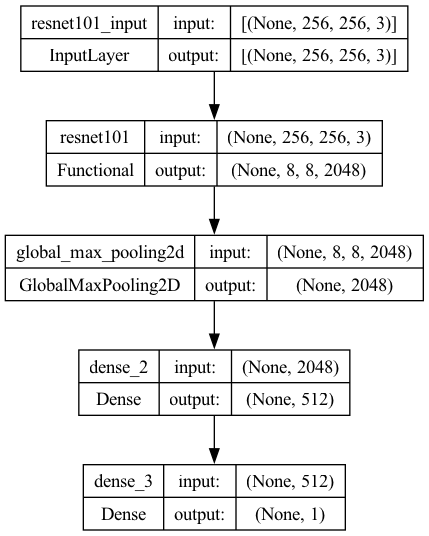

In [34]:
plot_model(resnet101_model, to_file='resnet101_model.png', show_shapes=True)

In [35]:
# Fit model on traning dataset
resnet101_model_history = resnet101_model.fit(X_train1, y_train1, epochs=3, callbacks=[early_stopping_callback])

Epoch 1/3
94/94 [==============================] - 440s 5s/step - loss: 2.6015 - accuracy: 0.7800
Epoch 2/3
94/94 [==============================] - 398s 4s/step - loss: 0.1679 - accuracy: 0.9387
Epoch 3/3
94/94 [==============================] - 407s 4s/step - loss: 0.1087 - accuracy: 0.9573


In [36]:
# Perform predictions
y_pred_resnet101_model = resnet101_model.predict(X_test1)

16/16 [==============================] - 71s 4s/step


In [37]:
y_pred_class_resnet101_model = (y_pred_resnet101_model > 0.5).astype(int)

In [38]:
resnet101_model_accuracy = metrics.accuracy_score(y_test1, y_pred_class_resnet101_model)
resnet101_model_precision = metrics.precision_score(y_test1, y_pred_class_resnet101_model)
resnet101_model_recall = metrics.recall_score(y_test1, y_pred_class_resnet101_model)
resnet101_model_f1_score = metrics.f1_score(y_test1, y_pred_class_resnet101_model)
resnet101_model_auc_score = metrics.roc_auc_score(y_test1, y_pred_class_resnet101_model)

print(f"Accuracy: {resnet101_model_accuracy}")
print(f"Precision: {resnet101_model_precision}")
print(f"Recall: {resnet101_model_recall}")
print(f"F1 Score: {resnet101_model_f1_score}")
print(f"AUC Score: {resnet101_model_auc_score}")

Accuracy: 0.946
Precision: 0.9901639344262295
Recall: 0.9263803680981595
F1 Score: 0.9572107765451663
AUC Score: 0.9545694943939073


In [39]:
resnet101_model_confusion_matrix = metrics.confusion_matrix(y_test1, y_pred_class_resnet101_model)
print(resnet101_model_confusion_matrix)

[[171   3]
 [ 24 302]]


# Classification Model on VGG19

In [40]:
# Load pre-trained VGG19 model without the top (fully connected) layers
base_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), pooling=None)

# Freeze the layers of the pre-trained VGG19 model
for layer in base_model.layers:
    layer.trainable = False

# Build custom model on top of the pre-trained VGG19
vgg19_model = Sequential()
vgg19_model.add(base_model)
vgg19_model.add(GlobalMaxPooling2D())
vgg19_model.add(Dense(512, activation='relu'))
vgg19_model.add(Dense(1, activation='sigmoid'))

In [41]:
# Compile the model
vgg19_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
# Print Model Summary
vgg19_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 global_max_pooling2d_1 (Gl  (None, 512)               0         
 obalMaxPooling2D)                                               
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 20287553 (77.39 MB)
Trainable params: 263169 (1.00 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


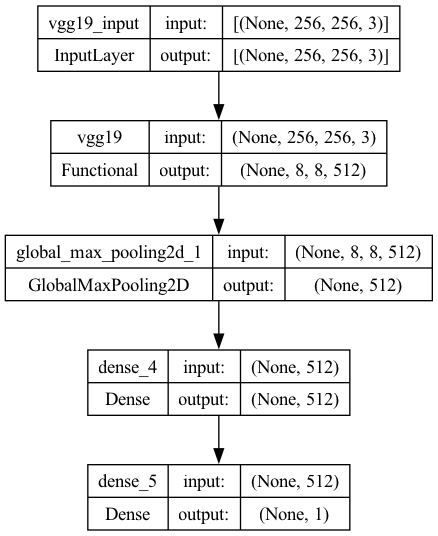

In [43]:
plot_model(vgg19_model, to_file='vgg19_model.png', show_shapes=True)

In [44]:
# Fit model on traning dataset
vgg19_model_history = vgg19_model.fit(X_train1, y_train1, epochs=3, callbacks=[early_stopping_callback])

Epoch 1/3
94/94 [==============================] - 624s 7s/step - loss: 3.2574 - accuracy: 0.8217
Epoch 2/3
94/94 [==============================] - 570s 6s/step - loss: 0.5095 - accuracy: 0.9050
Epoch 3/3
94/94 [==============================] - 513s 5s/step - loss: 0.1678 - accuracy: 0.9523


In [45]:
# Perform predictions
y_pred_vgg19_model = vgg19_model.predict(X_test1)

16/16 [==============================] - 80s 5s/step


In [46]:
y_pred_class_vgg19_model = (y_pred_vgg19_model > 0.5).astype(int)

In [47]:
vgg19_model_accuracy = metrics.accuracy_score(y_test1, y_pred_class_vgg19_model)
vgg19_model_precision = metrics.precision_score(y_test1, y_pred_class_vgg19_model)
vgg19_model_recall = metrics.recall_score(y_test1, y_pred_class_vgg19_model)
vgg19_model_f1_score = metrics.f1_score(y_test1, y_pred_class_vgg19_model)
vgg19_model_auc_score = metrics.roc_auc_score(y_test1, y_pred_class_vgg19_model)

print(f"Accuracy: {vgg19_model_accuracy}")
print(f"Precision: {vgg19_model_precision}")
print(f"Recall: {vgg19_model_recall}")
print(f"F1 Score: {vgg19_model_f1_score}")
print(f"AUC Score: {vgg19_model_auc_score}")

Accuracy: 0.85
Precision: 0.9466192170818505
Recall: 0.8159509202453987
F1 Score: 0.8764415156507412
AUC Score: 0.8648720118468373


In [48]:
vgg19_model_confusion_matrix = metrics.confusion_matrix(y_test1, y_pred_class_vgg19_model)
print(vgg19_model_confusion_matrix)

[[159  15]
 [ 60 266]]


# Classification Model on Xception

In [49]:
# Load pre-trained Xception model without the top (fully connected) layers
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), pooling=None)

# Freeze the layers of the pre-trained Xception model
for layer in base_model.layers:
    layer.trainable = False

# Build custom model on top of the pre-trained Xception
xception_model = Sequential()
xception_model.add(base_model)
xception_model.add(GlobalMaxPooling2D())
xception_model.add(Dense(512, activation='relu'))
xception_model.add(Dense(1, activation='sigmoid'))

In [50]:
# Compile the model
xception_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
# Print Model Summary
xception_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_max_pooling2d_2 (Gl  (None, 2048)              0         
 obalMaxPooling2D)                                               
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dense_7 (Dense)             (None, 1)                 513       
                                                                 
Total params: 21911081 (83.58 MB)
Trainable params: 1049601 (4.00 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


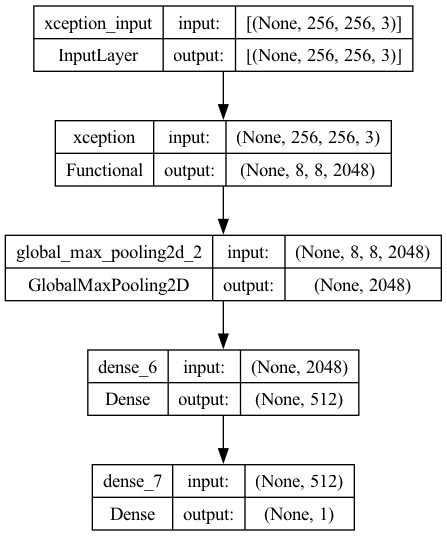

In [52]:
plot_model(xception_model, to_file='xception_model.png', show_shapes=True)

In [53]:
# Fit model on traning dataset
xception_model_history = xception_model.fit(X_train1, y_train1, epochs=3, callbacks=[early_stopping_callback])

Epoch 1/3
94/94 [==============================] - 189s 2s/step - loss: 4.6784 - accuracy: 0.6340
Epoch 2/3
94/94 [==============================] - 190s 2s/step - loss: 0.6639 - accuracy: 0.7503
Epoch 3/3
94/94 [==============================] - 177s 2s/step - loss: 0.3711 - accuracy: 0.8507


In [54]:
# Perform predictions
y_pred_xception_model = xception_model.predict(X_test1)

16/16 [==============================] - 32s 2s/step


In [55]:
y_pred_class_xception_model = (y_pred_xception_model > 0.5).astype(int)

In [56]:
xception_model_accuracy = metrics.accuracy_score(y_test1, y_pred_class_xception_model)
xception_model_precision = metrics.precision_score(y_test1, y_pred_class_xception_model)
xception_model_recall = metrics.recall_score(y_test1, y_pred_class_xception_model)
xception_model_f1_score = metrics.f1_score(y_test1, y_pred_class_xception_model)
xception_model_auc_score = metrics.roc_auc_score(y_test1, y_pred_class_xception_model)

print(f"Accuracy: {xception_model_accuracy}")
print(f"Precision: {xception_model_precision}")
print(f"Recall: {xception_model_recall}")
print(f"F1 Score: {xception_model_f1_score}")
print(f"AUC Score: {xception_model_auc_score}")

Accuracy: 0.728
Precision: 0.8492647058823529
Recall: 0.7085889570552147
F1 Score: 0.7725752508361203
AUC Score: 0.7364783865735844


In [57]:
xception_model_confusion_matrix = metrics.confusion_matrix(y_test1, y_pred_class_xception_model)
print(xception_model_confusion_matrix)

[[133  41]
 [ 95 231]]


# Classification Model on MobileNet

In [58]:
# Load pre-trained MobileNetV2 model without the top (fully connected) layers
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), pooling=None, classifier_activation="softmax")

# Freeze the layers of the pre-trained MobileNetV2 model
for layer in base_model.layers:
    layer.trainable = False

# Build custom model on top of the pre-trained MobileNetV2
mobilenet_model = Sequential()
mobilenet_model.add(base_model)
mobilenet_model.add(GlobalMaxPooling2D())
mobilenet_model.add(Dense(512, activation='relu'))
mobilenet_model.add(Dense(1, activation='sigmoid'))

In [59]:
# Compile the model
mobilenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
# Print Model Summary
mobilenet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_max_pooling2d_3 (Gl  (None, 1280)              0         
 obalMaxPooling2D)                                               
                                                                 
 dense_8 (Dense)             (None, 512)               655872    
                                                                 
 dense_9 (Dense)             (None, 1)                 513       
                                                                 
Total params: 2914369 (11.12 MB)
Trainable params: 656385 (2.50 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


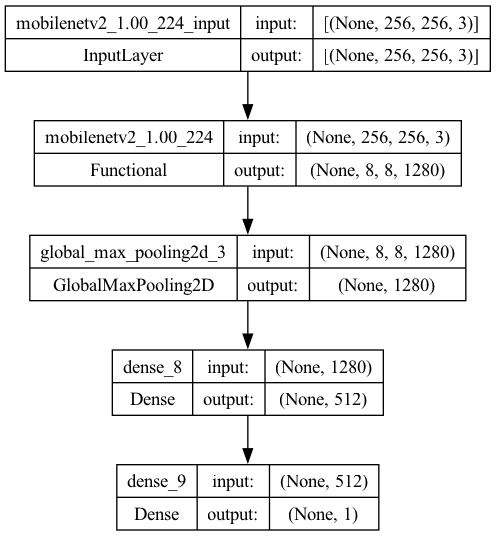

In [61]:
plot_model(mobilenet_model, to_file='mobilenet_model.png', show_shapes=True)

In [62]:
# Fit model on traning dataset
history = mobilenet_model.fit(X_train1, y_train1, epochs=3, callbacks=[early_stopping_callback])

Epoch 1/3
94/94 [==============================] - 72s 739ms/step - loss: 1.2270 - accuracy: 0.6977
Epoch 2/3
94/94 [==============================] - 68s 722ms/step - loss: 0.3621 - accuracy: 0.8390
Epoch 3/3
94/94 [==============================] - 64s 685ms/step - loss: 0.2833 - accuracy: 0.8790


In [63]:
# Perform predictions
y_pred = mobilenet_model.predict(X_test1)

16/16 [==============================] - 11s 661ms/step


In [64]:
y_pred_class = (y_pred > 0.5).astype(int)

In [65]:
mobilenet_model_accuracy = metrics.accuracy_score(y_test1, y_pred_class)
mobilenet_model_precision = metrics.precision_score(y_test1, y_pred_class)
mobilenet_model_recall = metrics.recall_score(y_test1, y_pred_class)
mobilenet_model_f1_score = metrics.f1_score(y_test1, y_pred_class)
mobilenet_model_auc_score = metrics.roc_auc_score(y_test1, y_pred_class)

print(f"Accuracy: {mobilenet_model_accuracy}")
print(f"Precision: {mobilenet_model_precision}")
print(f"Recall: {mobilenet_model_recall}")
print(f"F1 Score: {mobilenet_model_f1_score}")
print(f"AUC Score: {mobilenet_model_auc_score}")

Accuracy: 0.812
Precision: 0.9566929133858267
Recall: 0.745398773006135
F1 Score: 0.8379310344827586
AUC Score: 0.8410901911007685


In [66]:
mobilenet_model_confusion_matrix = metrics.confusion_matrix(y_test1, y_pred_class)
print(mobilenet_model_confusion_matrix)

[[163  11]
 [ 83 243]]


### Compare Models Accuracy and Other metrics

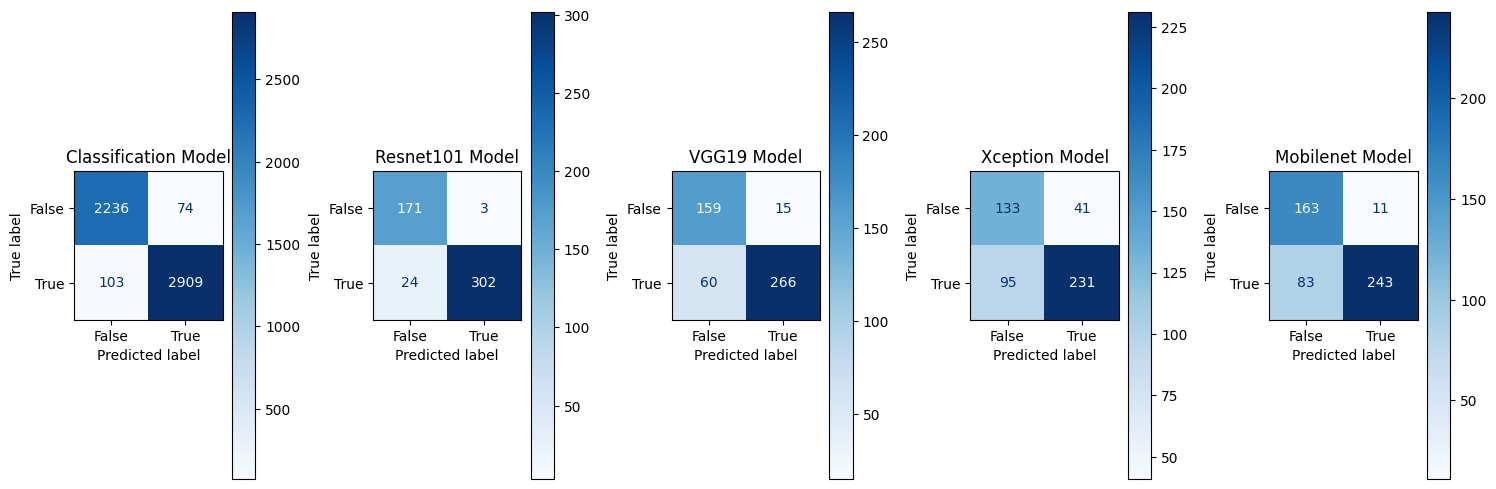

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion Matrix Plots
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

models = ["Classification Model", "Resnet101 Model", "VGG19 Model", "Xception Model", "Mobilenet Model"]
models_confusion_metrix = [confusion_matrix, resnet101_model_confusion_matrix, vgg19_model_confusion_matrix, xception_model_confusion_matrix, mobilenet_model_confusion_matrix]

axis = 0
for model, cf in zip(models, models_confusion_metrix):
    # Plot confusion matrix for Model A
    disp_A = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=['False', 'True'])
    disp_A.plot(ax=axes[axis], cmap=plt.cm.Blues, xticks_rotation='horizontal')
    axes[axis].set_title(model)
    axis += 1

plt.tight_layout()
plt.show()


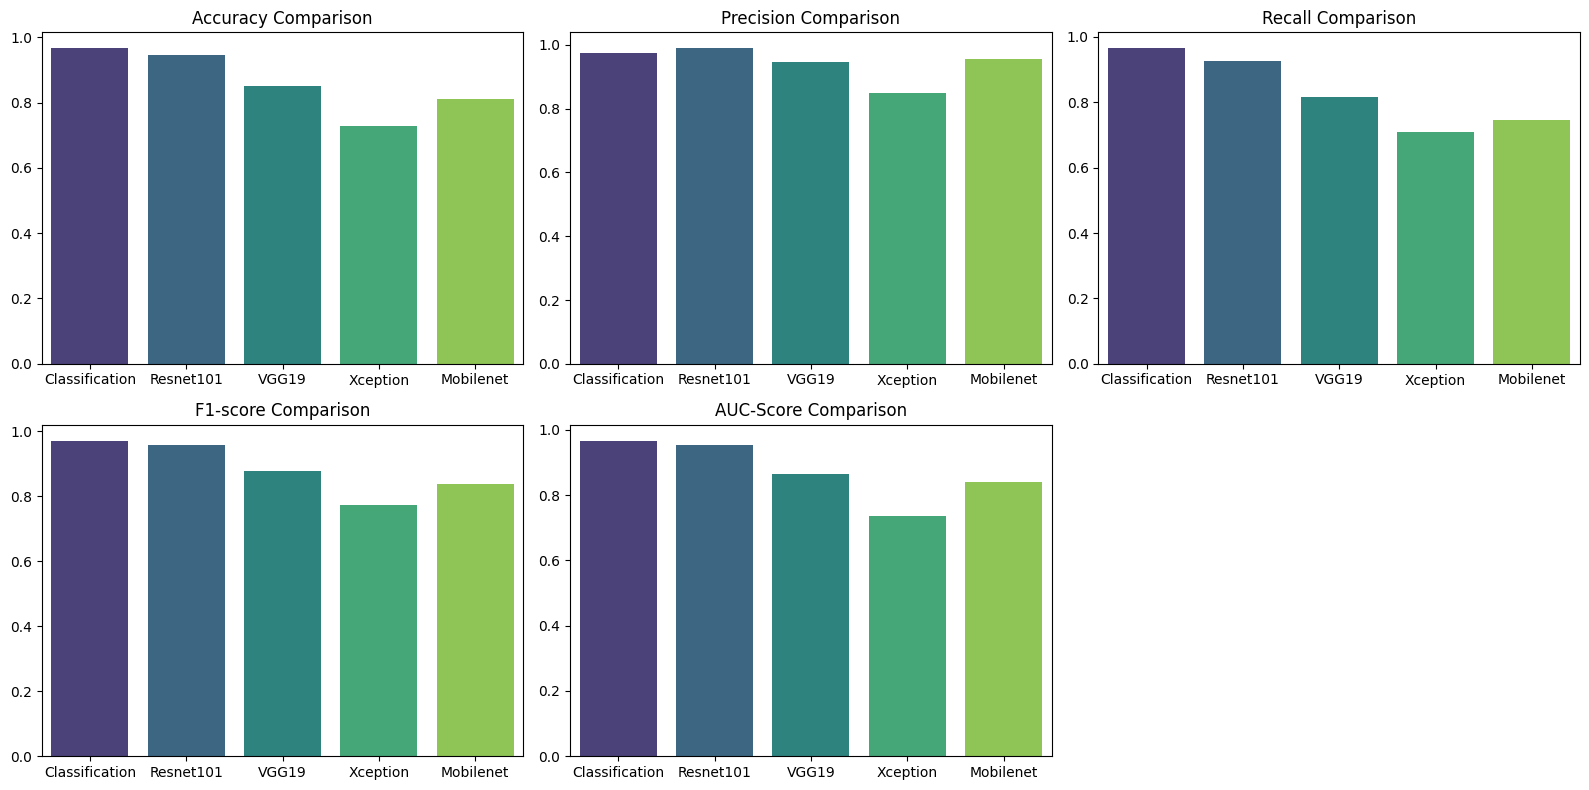

In [135]:

# Evaluation Metrics Comparison
models = ["Classification", "Resnet101", "VGG19", "Xception", "Mobilenet"]
accuracies = [accuracy, resnet101_model_accuracy, vgg19_model_accuracy, xception_model_accuracy, mobilenet_model_accuracy]
precisions = [precision, resnet101_model_precision, vgg19_model_precision, xception_model_precision, mobilenet_model_precision]
recalls = [recall, resnet101_model_recall, vgg19_model_recall, xception_model_recall, mobilenet_model_recall]
f1_scores = [f1_score, resnet101_model_f1_score, vgg19_model_f1_score, xception_model_f1_score, mobilenet_model_f1_score]
auc_scores = [auc_score, resnet101_model_auc_score, vgg19_model_auc_score, xception_model_auc_score, mobilenet_model_auc_score]
plt.figure(figsize=(16, 8))

# Accuracy comparison
plt.subplot(2, 3, 1)
sns.barplot(x=models, y=accuracies, hue=models, palette='viridis', legend=False)
plt.title('Accuracy Comparison')

# Precision comparison
plt.subplot(2, 3, 2)
sns.barplot(x=models, y=precisions, hue=models, palette='viridis', legend=False)
plt.title('Precision Comparison')

# Recall comparison
plt.subplot(2, 3, 3)
sns.barplot(x=models, y=recalls, hue=models, palette='viridis', legend=False)
plt.title('Recall Comparison')

# F1-score comparison
plt.subplot(2, 3, 4)
sns.barplot(x=models, y=f1_scores, hue=models, palette='viridis', legend=False)
plt.title('F1-score Comparison')

# AUC-score comparison
plt.subplot(2, 3, 5)
sns.barplot(x=models, y=auc_scores, hue=models, palette='viridis', legend=False)
plt.title('AUC-Score Comparison')

plt.tight_layout()
plt.show()

In [136]:
import pandas as pd

# Data to perform comparision between all the models
models = ["Classification", "Resnet101", "VGG19", "Xception", "Mobilenet"]
accuracies = [accuracy, resnet101_model_accuracy, vgg19_model_accuracy, xception_model_accuracy, mobilenet_model_accuracy]
precisions = [precision, resnet101_model_precision, vgg19_model_precision, xception_model_precision, mobilenet_model_precision]
recalls = [recall, resnet101_model_recall, vgg19_model_recall, xception_model_recall, mobilenet_model_recall]
f1_scores = [f1_score, resnet101_model_f1_score, vgg19_model_f1_score, xception_model_f1_score, mobilenet_model_f1_score]
auc_scores = [auc_score, resnet101_model_auc_score, vgg19_model_auc_score, xception_model_auc_score, mobilenet_model_auc_score]

# Create DataFrame
data = {
    'Model': models,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1-score': f1_scores,
    'AUC-score': auc_scores
}
df = pd.DataFrame(data)

# Print DataFrame
print(df)

            Model  Accuracy  Precision    Recall  F1-score  AUC-score
0  Classification  0.966742   0.975193  0.965803  0.970475   0.966884
1       Resnet101  0.946000   0.990164  0.926380  0.957211   0.954569
2           VGG19  0.850000   0.946619  0.815951  0.876442   0.864872
3        Xception  0.728000   0.849265  0.708589  0.772575   0.736478
4       Mobilenet  0.812000   0.956693  0.745399  0.837931   0.841090
